## Name: Nguyen Minh Huy Duong
### Assignment 1 Bonus

#### Question 1

In [1]:
# Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importing the dataset
dataset = pd.read_csv("fashion_mnist1.csv")
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0]

In [3]:
# Normalize the data by subtracting the mean
X_centered = X - X.mean(axis=0)

In [4]:
# Perform Singular Value Decomposition
U, s, Vt = np.linalg.svd(X_centered)

# Get the first two principal components
c1 = Vt.T[:, 0]  # First principal component
c2 = Vt.T[:, 1]  # Second principal component

In [5]:
# Project the data onto the first two components
X_pca_2d = np.array(X_centered @ Vt.T[:, :2])  # Projection on the first two principal components

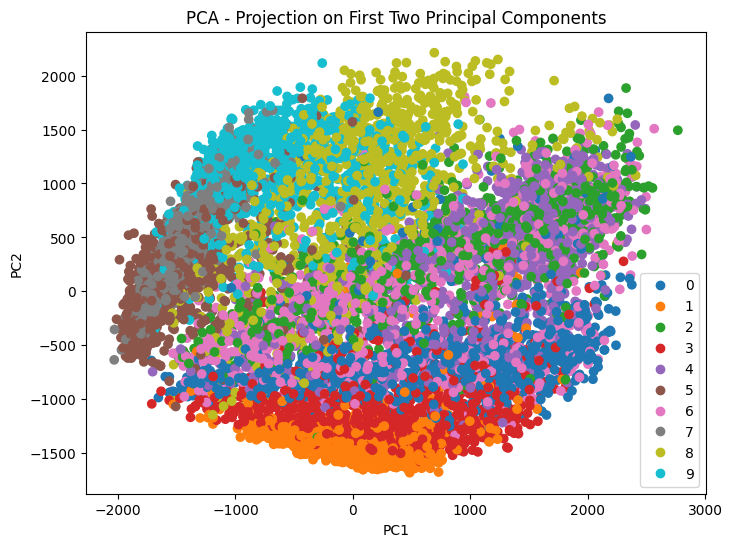

In [6]:
# Create a 2D scatter plot with colors based on the labels (y)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='tab10')

# Add legend and labels
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(y)))
plt.title("PCA - Projection on First Two Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


#### 1.2

In [7]:
# Select 10 images
images = []
labels = []

for label in range(10):
    images.append(X[y==label].iloc[0, :]) # Select first image for each label
    labels.append(label)

images = np.array(images)

In [8]:
def compress_image(image, k):
    # Apply SVD
    U, S, Vt = np.linalg.svd(image)
    
    # Keep only the first k components (U_k, Sigma_k, V_k)
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    
    # Reconstruct the image using the reduced components
    compressed_image = np.dot(U_k, np.dot(S_k, Vt_k))
    
    return compressed_image

In [9]:
def show_image(images, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    
    for i in range(10):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.show()

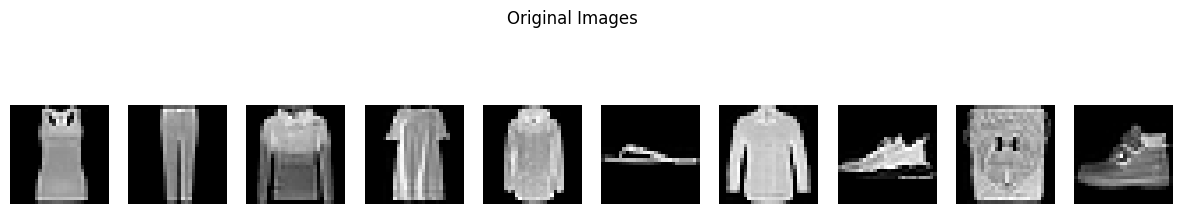

In [10]:
# Reshape the 784-pixel flat image into a 28x28 image
images_reshaped = [image.reshape(28, 28) for image in images]
show_image(images_reshaped, "Original Images")


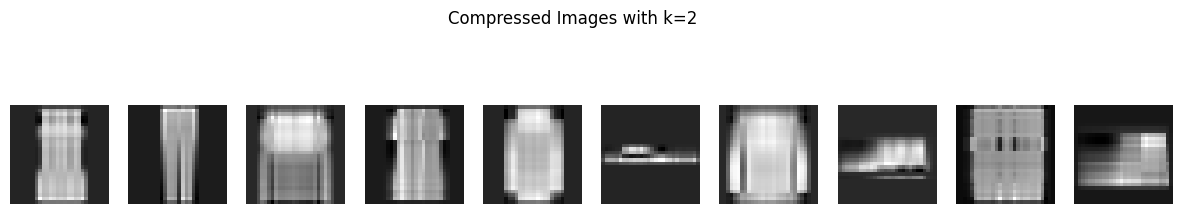

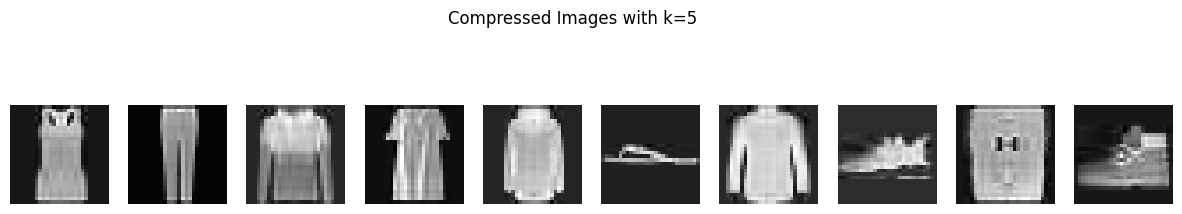

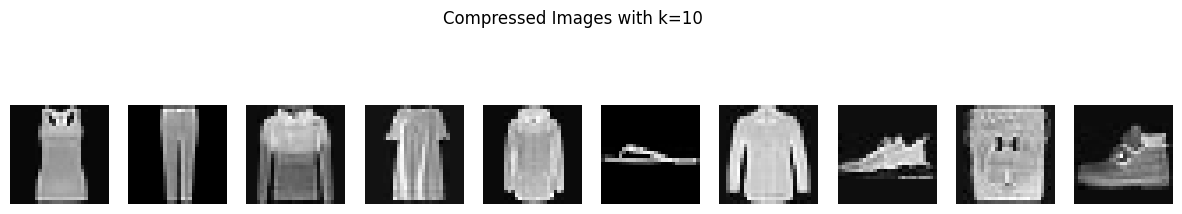

In [11]:
for k in [2, 5, 10]:
    compressed_images = [compress_image(image, k) for image in images_reshaped]
    show_image(compressed_images, f"Compressed Images with k={k}")

### Question 2

#### 2.1 Built t-SNE algorithm from scratch 
Source for algorithms: `https://towardsdatascience.com/t-sne-from-scratch-ft-numpy-172ee2a61df7`

In [12]:
# Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# Importing the dataset
dataset = pd.read_csv("fashion_mnist1.csv")
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0]

X = X.to_numpy()

In [14]:
def calculate_p_ij(X, perplexity=10):
    n = len(X)

    print("Computing Pairwise Affinities....")

    p_ij = np.zeros(shape=(n, n))
    for i in range(0, n):
        # Equation 1 numerator
        diff = X[i] - X
        σ_i = grid_search(diff, i, perplexity)  # Grid Search for σ_i
        norm = np.linalg.norm(diff, axis=1)
        p_ij[i, :] = np.exp(-(norm**2) / (2 * σ_i**2))

        # Set p = 0 when j = i
        np.fill_diagonal(p_ij, 0)

        # Equation 1
        p_ij[i, :] = p_ij[i, :] / np.sum(p_ij[i, :])

    # Set 0 values to minimum numpy value (ε approx. = 0)
    e = np.nextafter(0, 1)
    p_ij = np.maximum(p_ij, e)

    print("Completed Pairwise Affinities Matrix. \n")

    return p_ij

In [15]:
def grid_search(diff_i, i, perplexity):
    result = np.inf  # Set first result to be infinity

    norm = np.linalg.norm(diff_i, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for o_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # Equation 1 Numerator
        p = np.exp(-(norm**2) / (2 * o_search**2))

        # Set p = 0 when i = j
        p[i] = 0

        # Equation 1 (ε -> 0)
        e = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), e)

        # Shannon Entropy
        H = -np.sum(p_new * np.log2(p_new))

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            o = o_search

    return o

In [16]:
def get_symmetric_p_ij(p_ij):
    print("Computing Symmetric p_ij matrix....")

    n = len(p_ij)
    p_ij_symmetric = np.zeros(shape=(n, n))
    for i in range(0, n):
        for j in range(0, n):
            p_ij_symmetric[i, j] = (p_ij[i, j] + p_ij[j, i]) / (2 * n)

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    p_ij_symmetric = np.maximum(p_ij_symmetric, ε)

    print("Completed Symmetric p_ij Matrix. \n")

    return p_ij_symmetric

In [17]:
def initialization(X, n_dimensions=2, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Random initialization with small values
    y0 = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))
    
    return y0

In [18]:
def calculate_q_ij(Y):

    n = len(Y)
    q_ij = np.zeros(shape=(n, n))

    for i in range(0, n):
        # Equation 4 Numerator
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1)
        q_ij[i, :] = (1 + norm**2) ** (-1)

    # Set p = 0 when j = i
    np.fill_diagonal(q_ij, 0)

    # Equation 4
    q_ij = q_ij / q_ij.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    q_ij = np.maximum(q_ij, ε)

    return q_ij

In [19]:
def get_gradient(p_ij, q_ij, Y):
    n = len(p_ij)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        # Equation 5
        diff = Y[i] - Y
        A = np.array([(p_ij[i, :] - q_ij[i, :])])
        B = np.array([(1 + np.linalg.norm(diff, axis=1)) ** (-1)])
        C = diff
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient

In [20]:
def tsne(X, n_dimensions=2, perplexity=10, iteration_number=1000, learning_rate=200, momentum=0.8, random_seed=135):
    n = len(X)

    # Get original affinities matrix
    p_ij = calculate_p_ij(X, perplexity)
    p_ij_symmetric = get_symmetric_p_ij(p_ij)

    # Initialization
    Y = np.zeros(shape=(iteration_number, n, n_dimensions))
    Y_minus1 = np.zeros(shape=(n, n_dimensions))
    Y[0] = Y_minus1
    Y1 = initialization(X, n_dimensions, random_seed)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, iteration_number - 1):
        # Get Low Dimensional Affinities
        q_ij = calculate_q_ij(Y[t])

        # Get Gradient of Cost Function
        gradient = get_gradient(p_ij_symmetric, q_ij, Y[t])

        # Update Rule
        Y[t + 1] = Y[t] - learning_rate * gradient + momentum * (Y[t] - Y[t - 1])  # Use negative gradient

        if t % 50 == 0 or t == 1:
            print(f"Complete Iteration {t}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}"
    )
    solution = Y[-1]

    return solution, Y

In [21]:
def plot_t_sne(Y, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='tab10')
    plt.legend(handles=scatter.legend_elements()[0], labels=list(set(labels)))
    plt.title("t-SNE Result:" + title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()



#### 2.2 Using the t-SNE method with 5 different hyperparemeters

In [22]:
hyperparameter = [
    {"perplexity": 2,"iteration_number": 200, "learning_rate": 50,"momentum": 0.5,"random_seed": 123},
    {"perplexity": 4,"iteration_number": 400, "learning_rate": 100,"momentum": 0.6,"random_seed": 234},
    {"perplexity": 6,"iteration_number": 600, "learning_rate": 150,"momentum": 0.7,"random_seed": 345},
    {"perplexity": 8,"iteration_number": 800, "learning_rate": 200,"momentum": 0.8,"random_seed": 456},
    {"perplexity": 10,"iteration_number": 1000, "learning_rate": 200,"momentum": 0.9,"random_seed": 135}, 
]

Y_2d = []
for param in hyperparameter:
    print("Starting hyperparameter: \n" + str(param))
    y_2d, Y = tsne(X, 2, **param)
    Y_2d.append(y_2d)

Starting hyperparameter: 
{'perplexity': 2, 'iteration_number': 200, 'learning_rate': 50, 'momentum': 0.5, 'random_seed': 123}
Computing Pairwise Affinities....


C:\Users\minhh\AppData\Local\Temp\ipykernel_8332\2970568124.py:16: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), e)


Completed Pairwise Affinities Matrix. 

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 

Optimizing Low Dimensional Embedding....
Complete Iteration 1
Complete Iteration 50
Complete Iteration 100
Complete Iteration 150
Completed Low Dimensional Embedding: Final Value of Cost Function is 8.079632367965237
Starting hyperparameter: 
{'perplexity': 4, 'iteration_number': 400, 'learning_rate': 100, 'momentum': 0.6, 'random_seed': 234}
Computing Pairwise Affinities....
Completed Pairwise Affinities Matrix. 

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 

Optimizing Low Dimensional Embedding....
Complete Iteration 1
Complete Iteration 50
Complete Iteration 100
Complete Iteration 150
Complete Iteration 200
Complete Iteration 250
Complete Iteration 300
Complete Iteration 350
Completed Low Dimensional Embedding: Final Value of Cost Function is 5.072315845094989
Starting hyperparameter: 
{'perplexity': 6, 'iteration_number': 600, 'learning_rate': 150,

In [36]:
# Function to compute centroid for each label
def compute_centroids(Y, labels):
    centroids = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        centroid = np.mean(Y[labels == label], axis=0)
        centroids.append(centroid)
    return np.array(centroids)

# Compute sum of distances D between centroids
def compute_sum_of_distances(centroids):
    n = centroids.shape[0]
    D = 0
    for i in range(n):
        for j in range(i + 1, n):
            D += np.linalg.norm(centroids[i] - centroids[j])
    return D

for i in range(len(hyperparameter)):
    centroids = compute_centroids(Y_2d[i], y)
    D = compute_sum_of_distances(centroids)
    print(f"Calculate distances for hyperparameter: {hyperparameter[i]}")
    print(f"Sum of distances D among centroids: {D} \n")

Calculate distances for hyperparameter: {'perplexity': 2, 'iteration_number': 200, 'learning_rate': 50, 'momentum': 0.5, 'random_seed': 123}
Sum of distances D among centroids: 0.4868946119093292 

Calculate distances for hyperparameter: {'perplexity': 4, 'iteration_number': 400, 'learning_rate': 100, 'momentum': 0.6, 'random_seed': 234}
Sum of distances D among centroids: 158.03808252617662 

Calculate distances for hyperparameter: {'perplexity': 6, 'iteration_number': 600, 'learning_rate': 150, 'momentum': 0.7, 'random_seed': 345}
Sum of distances D among centroids: 556.242706534933 

Calculate distances for hyperparameter: {'perplexity': 8, 'iteration_number': 800, 'learning_rate': 200, 'momentum': 0.8, 'random_seed': 456}
Sum of distances D among centroids: 1600.3407814084255 

Calculate distances for hyperparameter: {'perplexity': 10, 'iteration_number': 1000, 'learning_rate': 200, 'momentum': 0.9, 'random_seed': 135}
Sum of distances D among centroids: 3606.0814707045624 



#### 2.3 Draw 2D plot for the 5 hyperparameter

hyperparameter: {'perplexity': 2, 'iteration_number': 200, 'learning_rate': 50, 'momentum': 0.5, 'random_seed': 123}


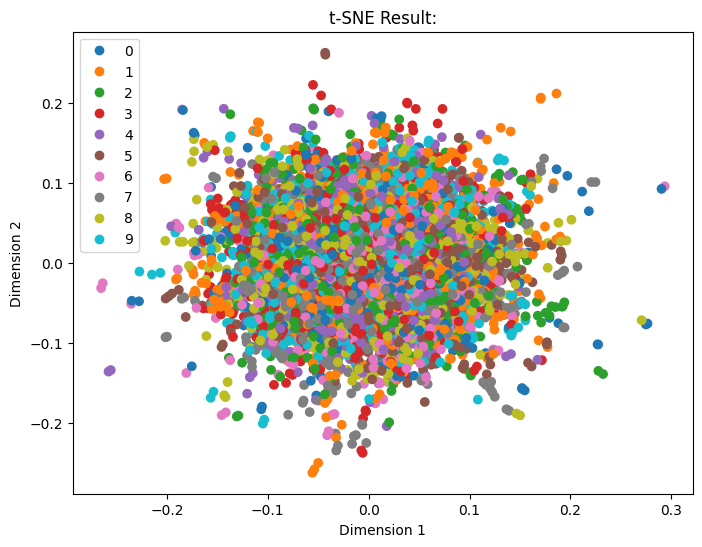

hyperparameter: {'perplexity': 4, 'iteration_number': 400, 'learning_rate': 100, 'momentum': 0.6, 'random_seed': 234}


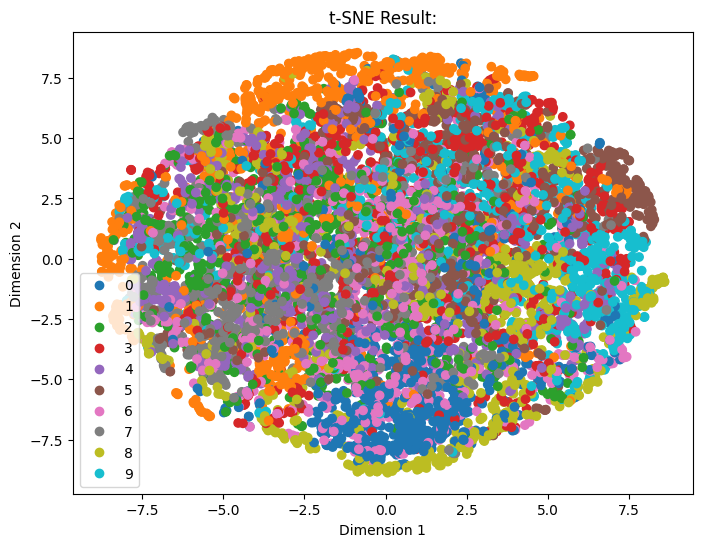

hyperparameter: {'perplexity': 6, 'iteration_number': 600, 'learning_rate': 150, 'momentum': 0.7, 'random_seed': 345}


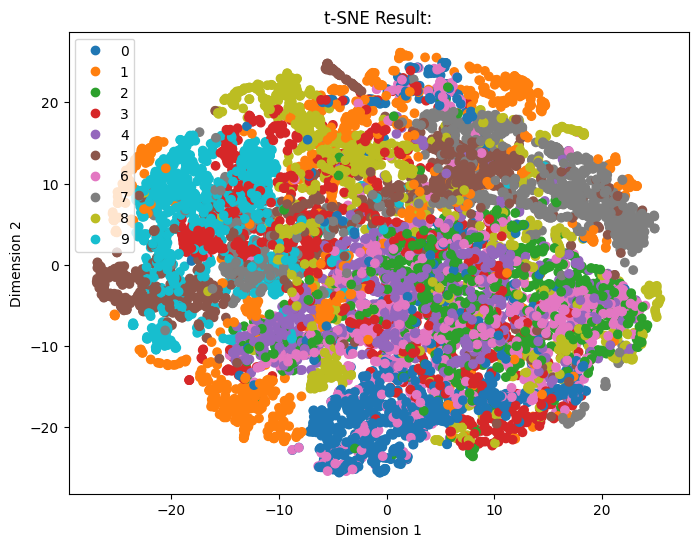

hyperparameter: {'perplexity': 8, 'iteration_number': 800, 'learning_rate': 200, 'momentum': 0.8, 'random_seed': 456}


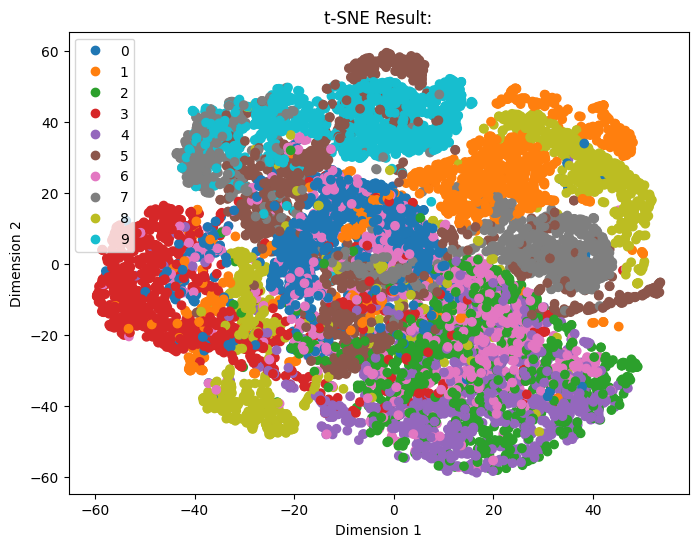

hyperparameter: {'perplexity': 10, 'iteration_number': 1000, 'learning_rate': 200, 'momentum': 0.9, 'random_seed': 135}


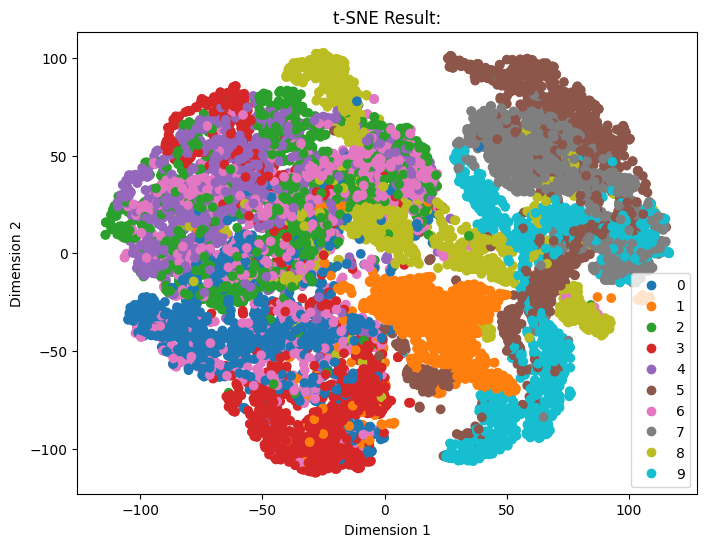

In [37]:
for i in range(len(hyperparameter)):
    print(f"hyperparameter: {hyperparameter[i]}")
    plot_t_sne(Y_2d[i], y, "")